# Air Quality Sensor: Data Cleanup

This notebook plots the raw data, explains the cleanup procedures, and then plots the results.  

There are two cleanups needed.  First, the MCP2003 eight-channel analog-to-digital converter chip, used to digitize the analog outputs of eight MQ sensors, fried itself on two different occasions.  The MQ data thus needs to be removed from the data sets from those days.  Second, either the Arduino Uno or the individual sensors occasionally "hiccup" and report a data point that is unphysically large or small.  This happens infrequenly enough that it does not effect the quality of the data. The most harmful effect is that Python rescales plots to reflect these spuriously high data points, compressing the view of the viable data. The solution taken here is to specify a maximum value for each data set, determined by eye after inspecting plots, above/below which to remove data points.

While the code to enact each data cleanup is written out explicitly here, it has also been incorporated as methods into the "suite" extension of pandas.DataFrame, written in the file SuitePanda.py.  

In [1]:
import numpy as np
import pandas as pd
import SuitePanda
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import os
import subprocess

import read_formatted

In [2]:
# make this notebook display wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
# setup for plots
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]

In [5]:
# find data files of the type 'suite'
findfiles = subprocess.run(['ls /home/rory/Arduino/python/archive/suite*'],
                            stdout=subprocess.PIPE,
                            shell=True)
fullpaths = findfiles.stdout.decode('utf-8').split('\n')
files = [fullpath.split('python/')[1] for fullpath in fullpaths[0:-2]]

In [21]:
# use read_formatted.read_panda to read data into pandas
justfiles = [f.split('/')[1] for f in files]
SweetPanda = read_formatted.read_panda(justfiles[1], raw=True)
for f in justfiles[2:]:
    SweetPanda = SweetPanda.append(read_formatted.read_panda(f, raw=True))

In [7]:
def my_annotate(ax,text,xy=(0,0),xytext=(0,0)):
    ax.annotate(text, 
                xytext=xytext, 
                xy = xy,
                ha='center',
                xycoords='axes fraction',
                fontsize=14,
                arrowprops={'facecolor':'black'})

## Removing Data from Damaged ADC
The MCP3008 ADC chip was damaged (overheated) on two occassions: around 07/10/2019 and 07/27/2019. On the first occasion, some bits from the digitization would still return, resulting in very "quantized" data between zero and full scale (5 V).  On the second occasion, the results were pretty uniformly zero.

All the needs to be done here is to "remove" the data points from the data set; this is easily none by replacing these values with NaN.

Text(0, 0.5, 'ADC Output (V)')

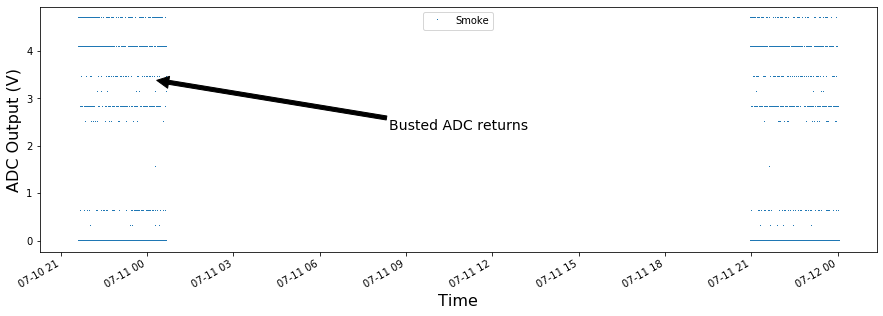

In [18]:
#Lesson in Pandas
#panda.loc['x'] searches for rows labelled 'x'
#apparently, it is quite smart.  Enter a day in MM/DD/YYYY format,
#and it picks out all data points from that day.  It also handles 'slicing'

#Plot 'Smoke' data from two days when ADC was busted
ax = SweetPanda.loc['07/10/2019':'07/12/2019'].plot(y='Smoke', 
                                                    style=',',
                                                    figsize=(15,5))
ax.annotate( 'Busted ADC returns', 
             xytext=(0.5,0.5),
             xy = (0.14,0.7),
             ha='center',
             xycoords='axes fraction',
             fontsize=14,
             arrowprops={'facecolor':'black'})
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('ADC Output (V)', fontsize=16)

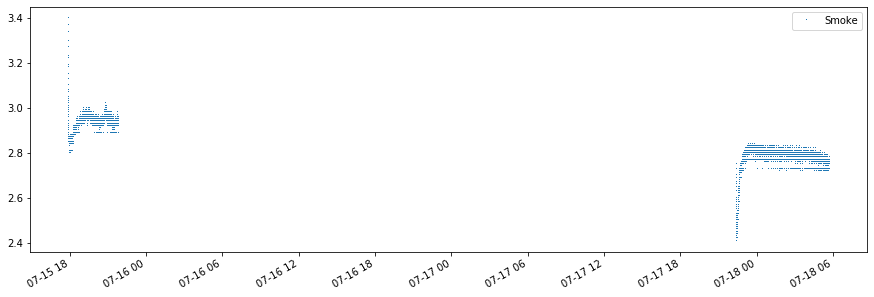

In [19]:
# demonstrate removal of data in 'Smoke' detector column 
SweetPanda.loc['07/10/2019':'07/12/2019', 'Smoke'] = np.nan
SweetPanda.loc['07/01/2019':'07/20/2019'].plot(y='Smoke', style=',', figsize=(15,5))

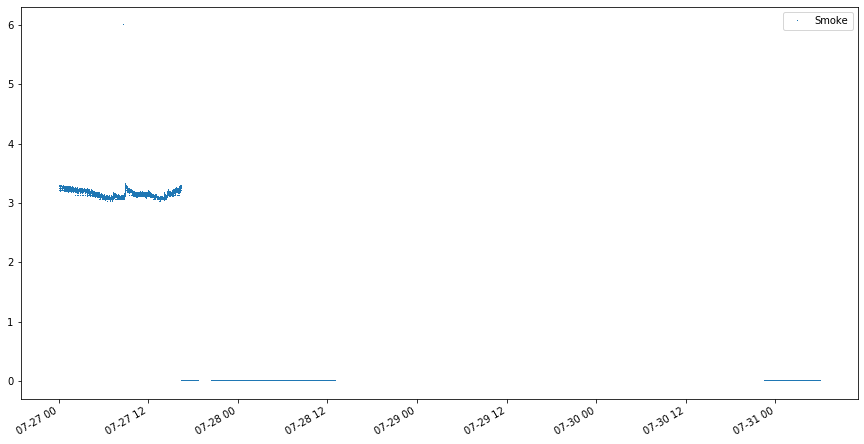

In [24]:
SweetPanda.loc['07/27/2019':'07/31/2019'].plot(y='Smoke', style=',')

/home/rory/Arduino/python/SuitePanda.py:110: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Text(0.46, 0.56, 'ADC busted')

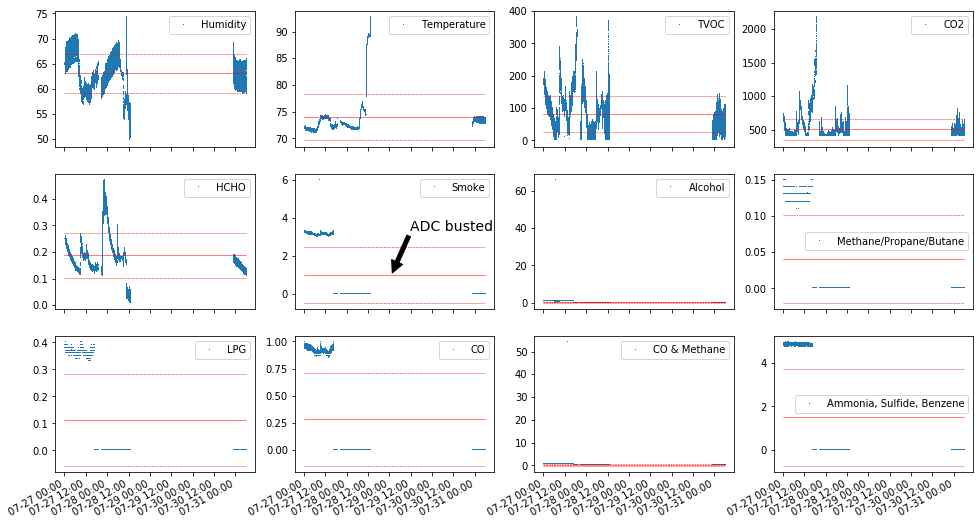

In [22]:
# second ADC breakage on 07/27 in middle of run, shortly after 16:26, until the move out of 
# the Stonehill apartment on 07/31
SweetPanda.loc['07/27/2019':'07/31/2019'].suite.SuitePlot()
ThisAxis = plt.gca()
ThisAxis.annotate('ADC busted', 
                 xytext=(0.46,0.56),
                 xy = (0.40,0.48),
                 ha='center',
                 xycoords='figure fraction',
                 fontsize=14,
                 arrowprops={'facecolor':'black'})

/home/rory/Arduino/python/SuitePanda.py:110: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


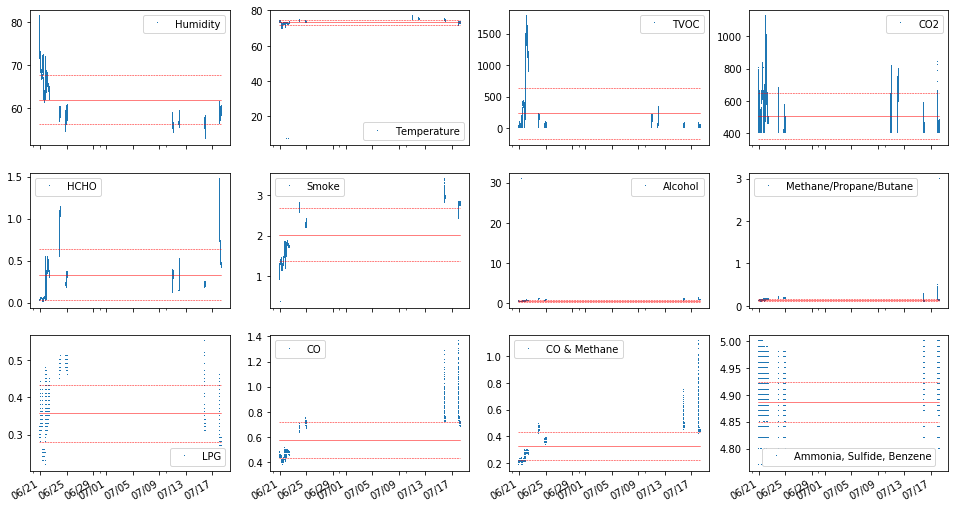

In [26]:
#Now remove all ADC channels for days on which ADC was busted
ADC_channel_names = ['Smoke', 'Alcohol', 'Methane/Propane/Butane', 'LPG', 
                     'CO', 'Hydrogen', 'CO & Methane', 'Ammonia, Sulfide, Benzene']
SweetPanda.loc['07/10/2019':'07/12/2019', ADC_channel_names] = np.nan
SweetPanda.loc['07/27/2019 16:25':'07/31/2019', ADC_channel_names] = np.nan
_ = SweetPanda.loc['06/15/2019':'07/20/2019'].suite.SuitePlot(format='%m/%d')

## Removing Data Burps
Second type of data clean-up: Arduino occasionally returns abnormally high values.  This happens infrequenly enough that it does not effect the quality of the data.  The most harmful effect is that Python rescales plots to reflect these spuriously high data points, compressing the view of the rest of the (viable) data.  You can see this in the plot above, especially for Alcohol and Temperature.  The approach here is to specify a maximum value for each data set, determined by eye after inspecting plots, above which to remove data points.  

A better solution might be to look at the differnce of consecutive data points (using np.diff) and make cuts based on that.  

In [27]:
MaxVal = {'Humidity':100.,
          'Temperature':100.,
          'TVOC':10000., 
          'CO2':10000., 
          'HCHO':10., 
          'Smoke':5., 
          'Alcohol':5.,
          'Methane/Propane/Butane':1., 
          'LPG':1.0, 
          'CO':1.0, 
          'Hydrogen':1.0, 
          'CO & Methane':1.0,
          'Ammonia, Sulfide, Benzene':5.
         }
for name,val in MaxVal.items():
    SweetPanda.loc[SweetPanda[name] > val, name] = np.nan

In [28]:
#Temperature also has anomalously low data points
SweetPanda.loc[SweetPanda['Temperature'] < 40, 'Temperature'] = np.nan

/home/rory/Arduino/python/SuitePanda.py:110: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 1080x576 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6fe4fdc950>,
       dtype=object))

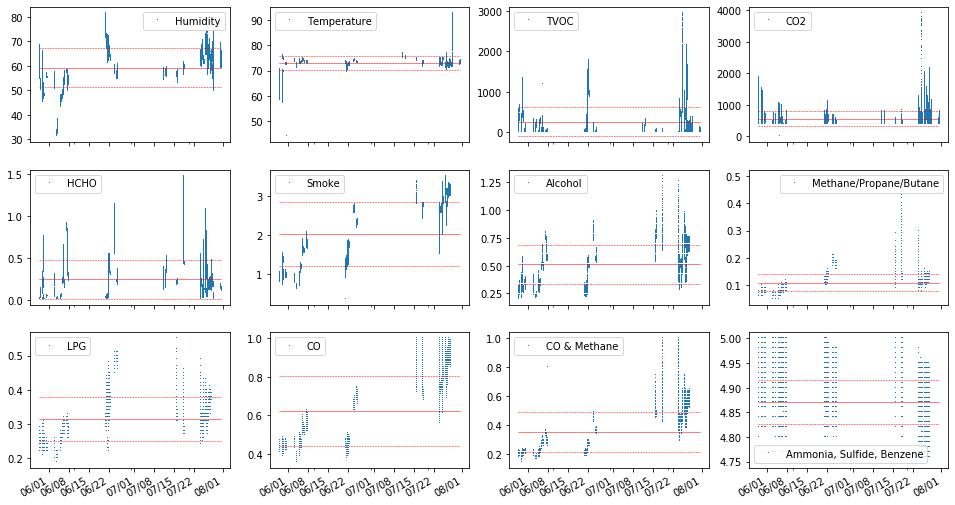

In [29]:
SweetPanda.suite.SuitePlot(format='%m/%d')